# Self-Drive Cars' Sentiment Analysis

- Implementing model based on previous notebook work

# 1)- Importing modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2)- Load Data

In [4]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('model.pkl')
df.shape

(15000, 2)

In [5]:
df.head()

,TEXT,Sent_type
443783,Unless you’re trying to buy me a Mercedes G-wa...,Neutral
229375,Ford recently made news by suspending producti...,Risky
20760,Just to get a closer look at the interior of o...,Neutral
337983,"In October 2014, General Motors got permission...",Risky
247040,I took a spin in a self-driving car today. My ...,Benefit


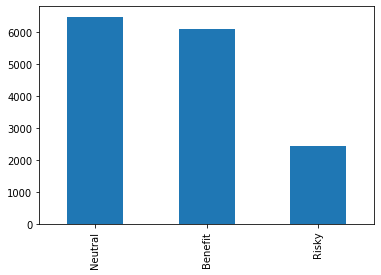

In [6]:
df.Sent_type.value_counts().plot(kind='bar')

In [8]:
df.Sent_type.value_counts(normalize=True)

Neutral    0.431200
Benefit    0.405933
Risky      0.162867
Name: Sent_type, dtype: float64

# 1)- Cleaning

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http','https','pictwittercom']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [10]:
df['cleaned']=[text_prepare(x) for x in df['TEXT']]

In [11]:
print(df.TEXT[:5])

443783    Unless you’re trying to buy me a Mercedes G-wa...
229375    Ford recently made news by suspending producti...
20760     Just to get a closer look at the interior of o...
337983    In October 2014, General Motors got permission...
247040    I took a spin in a self-driving car today. My ...
Name: TEXT, dtype: object


In [12]:
df.cleaned[:5]

443783    unless youre trying buy mercedes gwagon dont t...
229375    ford recently made news suspending production ...
20760     get closer look interior 2009 bmw 3 series con...
337983    october 2014 general motors got permission fli...
247040    took spin selfdriving car today safety driver ...
Name: cleaned, dtype: object

In [13]:
df.cleaned[4]

'jasons buying vw beetle cant stop calling bug boi'

### most common words

In [14]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('selfdriving', 2734),
 ('bmw', 2367),
 ('porsche', 2026),
 ('cars', 1978),
 ('motors', 1712),
 ('car', 1650),
 ('mercedes', 1604),
 ('audi', 1500),
 ('new', 1242),
 ('general', 1153)]

# RNN

- Applying LSTM

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [16]:
df.head()

,TEXT,Sent_type,cleaned
443783,Unless you’re trying to buy me a Mercedes G-wa...,Neutral,unless youre trying buy mercedes gwagon dont t...
229375,Ford recently made news by suspending producti...,Risky,ford recently made news suspending production ...
20760,Just to get a closer look at the interior of o...,Neutral,get closer look interior 2009 bmw 3 series con...
337983,"In October 2014, General Motors got permission...",Risky,october 2014 general motors got permission fli...
247040,I took a spin in a self-driving car today. My ...,Benefit,took spin selfdriving car today safety driver ...


In [17]:
y=df['Sent_type']

In [18]:
df['cleaned'].shape

(15000,)

In [19]:
X=df.cleaned

In [20]:
print(X.shape)
print(y.shape)

(15000,)
(15000,)


## Step1- Convert words to matrix

We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

- Vectorize tweet, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,000 words.
- Set the max number of words in each complaint at 280(max size limit for twitter is 280 ).


### i-I started by fitting a tokenizer on my document as in here:

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 280
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)

In [22]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 50253 unique tokens.


### ii- I wanted to check if my data is fitted correctly so I converted into sequence

In [23]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X.values)

In [24]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,2152.0,250.0,616.0,80.0,7.0,3560.0,50.0,592.0,2472.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17.0,1097.0,124.0,20.0,190.0,1626.0,3561.0,920.0,978.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29.0,878.0,70.0,744.0,2295.0,2.0,45.0,118.0,593.0,169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1290.0,1014.0,10.0,5.0,55.0,3992.0,3199.0,921.0,149.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,483.0,1525.0,1.0,6.0,32.0,285.0,89.0,570.0,92.0,308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It means that "two" is encoded as 153, "places" as 944 and so on...... "selfdriving" as 5 and finally "cars" as 3

In [25]:
df.head()

,TEXT,Sent_type,cleaned
443783,Unless you’re trying to buy me a Mercedes G-wa...,Neutral,unless youre trying buy mercedes gwagon dont t...
229375,Ford recently made news by suspending producti...,Risky,ford recently made news suspending production ...
20760,Just to get a closer look at the interior of o...,Neutral,get closer look interior 2009 bmw 3 series con...
337983,"In October 2014, General Motors got permission...",Risky,october 2014 general motors got permission fli...
247040,I took a spin in a self-driving car today. My ...,Benefit,took spin selfdriving car today safety driver ...


In [26]:
df['cleaned'][20760]

'get closer look interior 2009 bmw 3 series convertible wwwinstagramcom p bqoc2gulruu'

In [27]:
df['cleaned'][4]

'jasons buying vw beetle cant stop calling bug boi'

**google is encoded as 4. And cars as 3 . car as 2. Let's confirm our encoding scheme with one more**

In [29]:
df['cleaned'][247040]

'took spin selfdriving car today safety driver handsoff whole way yes car moving snapped pic future saedemodaypictwittercom 0wngmevwg4'

Perfect google is 4 and cars is 3

###  pad_sequence:To keep all vectors of same length, I will use pad_sequence

In [30]:
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [31]:
print('Shape of data tensor:', X_pd_sq.shape)

Shape of data tensor: (15000, 280)


To avoid AttributeError: 'numpy.ndarray' object has no attribute 'head', we will check in dataframe. Still input to neural network will be numpy array not dataframe

In [32]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,0,0,0,0,0,0,0,0,0,0,...,0,2152,250,616,80,7,3560,50,592,2472
1,0,0,0,0,0,0,0,0,0,0,...,1626,3561,920,978,10,5,846,847,2,11
2,0,0,0,0,0,0,0,0,0,0,...,878,70,744,2295,2,45,118,593,169,120
3,0,0,0,0,0,0,0,0,0,0,...,0,1290,1014,10,5,55,3992,3199,921,149
4,0,0,0,0,0,0,0,0,0,0,...,285,89,570,92,308,6,979,3993,784,39


**All in one step**

In [ ]:
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(X)
#X = tokenizer.texts_to_sequences(X)
#X = pad_sequences(X)

In [ ]:
#X_pd_sq.shape

## Step 2- Train-test split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd_sq,y,random_state=42)

In [34]:
X_train.shape, X_test.shape

((11250, 280), (3750, 280))

In [35]:
print(y_train.shape)
print(y_test.shape)

(11250,)
(3750,)


## Step 3- Encoding y-labeled feature

In [36]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

**this step is very important as we need to decode categorical variables into dummy**

In [37]:
y_train[:5]

319558    Benefit
154160    Benefit
240367    Benefit
361963    Benefit
244119      Risky
Name: Sent_type, dtype: object

In [38]:
y_train_ohe[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [39]:
y_test[:5]

171115    Benefit
271652    Neutral
225777      Risky
78578       Risky
9122      Benefit
Name: Sent_type, dtype: object

In [40]:
y_test_ohe[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

From above, we can see what is encoding scheme

- Neutral is 0,1,0
- Risky is 0,0,1
- Beneficial is 1,0,0

In [41]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['Neutral', 'Benefit', 'Risky']

In [42]:
len(unique_y_labels)

3

**Hence , our last dense layer will be of size 3

## Step 4- Build LSTM model

- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 3 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function


In [43]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
# for our padding seq
input_length=X_pd_sq.shape[1]
uniq_y_label=len(unique_y_labels)

In [44]:
X_pd_sq.shape[1]

280

In [45]:
uniq_y_label

3

In [50]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pd_sq.shape[1]))
#model.add(SpatialDropout1D(0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 280, 100)          500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 280, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 580,703
Trainable params: 580,703
Non-trainable params: 0
_________________________________________________________________
None


## Step 5- Train model

In [52]:
batch_size = 64
epochs = 15

In [53]:
from keras.callbacks import EarlyStopping

In [54]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10125 samples, validate on 1125 samples
Epoch 1/15
10125/10125 [==============================] - 154s 15ms/step - loss: 0.9199 - accuracy: 0.5668 - val_loss: 0.7394 - val_accuracy: 0.6773
Epoch 2/15
10125/10125 [==============================] - 155s 15ms/step - loss: 0.5065 - accuracy: 0.8119 - val_loss: 0.5812 - val_accuracy: 0.7884
Epoch 3/15
10125/10125 [==============================] - 153s 15ms/step - loss: 0.2972 - accuracy: 0.8993 - val_loss: 0.5912 - val_accuracy: 0.8053
Epoch 4/15
10125/10125 [==============================] - 155s 15ms/step - loss: 0.2166 - accuracy: 0.9313 - val_loss: 0.6584 - val_accuracy: 0.7991
Epoch 5/15
10125/10125 [==============================] - 156s 15ms/step - loss: 0.1650 - accuracy: 0.9472 - val_loss: 0.7392 - val_accuracy: 0.7778


In [55]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3750/3750 [==============================] - 24s 6ms/step
Test set
  Loss: 0.778
  Accuracy: 0.783


## Step 6- Evaluate

In [56]:
y_pred = model.predict(X_test)

In [57]:
y_pred[:5]

array([[5.9211308e-01, 2.4425059e-03, 4.0544447e-01],
       [7.2390134e-03, 9.8700273e-01, 5.7582562e-03],
       [2.7458286e-03, 1.9296386e-03, 9.9532449e-01],
       [9.7414193e-04, 2.9372901e-04, 9.9873215e-01],
       [9.8421186e-01, 7.3324400e-04, 1.5054807e-02]], dtype=float32)

**These are probabilities of output**

In [58]:
y_test_ohe[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [59]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

**Converting prob. into crisp classes i.e in 1D.**

In [60]:
y_test_class[:5]

array([0, 1, 2, 2, 0])

**By comparing from y_test_ohe, we can see that '1' in y_test_class means neutral. <br>
2 means [0,0,1] of y_test_ohe .It means we have Risky component<br>
0 means [1,0,0] which means beneficial**

In [61]:
y_pred_class[:5]

array([0, 1, 2, 2, 0])

### a)- Classification Report

In [62]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1510
           1       0.82      0.83      0.83      1607
           2       0.61      0.54      0.57       633

    accuracy                           0.78      3750
   macro avg       0.75      0.74      0.74      3750
weighted avg       0.78      0.78      0.78      3750



0 is Beneficial<br>
1 is Neutral <br>
2 is Risky<br>

In [63]:
y_test.value_counts()

Neutral    1607
Benefit    1510
Risky       633
Name: Sent_type, dtype: int64

### b)-Confusion Matrix

In [64]:
cm=confusion_matrix(y_test_class,y_pred_class)
print(cm)

[[1258  141  111]
 [ 161 1337  109]
 [ 141  150  342]]


In [65]:
y_test.value_counts()

Neutral    1607
Benefit    1510
Risky       633
Name: Sent_type, dtype: int64

<Figure size 720x720 with 0 Axes>

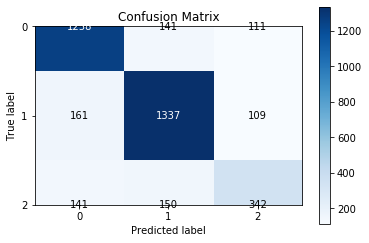

In [66]:
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class)
plt.show()

In [67]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

[[0.83311258 0.09337748 0.07350993]
 [0.10018668 0.83198507 0.06782825]
 [0.22274882 0.23696682 0.54028436]]


<Figure size 720x720 with 0 Axes>

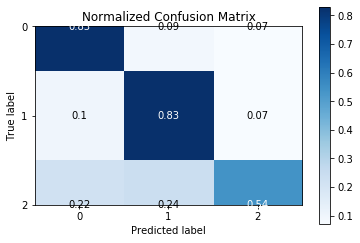

In [68]:
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class, normalize=True)
plt.show()

### c)- Loss and Accuracy

In [69]:
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9530
Training Loss: 0.1648


In [70]:
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.7832
Testing Loss:  0.7785


In [71]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

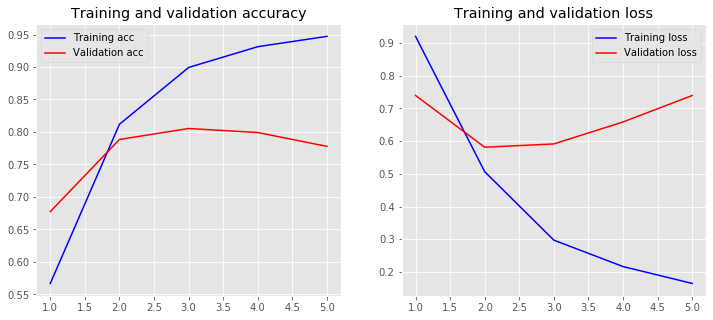

In [72]:
plot_history(history)

In [73]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history2(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

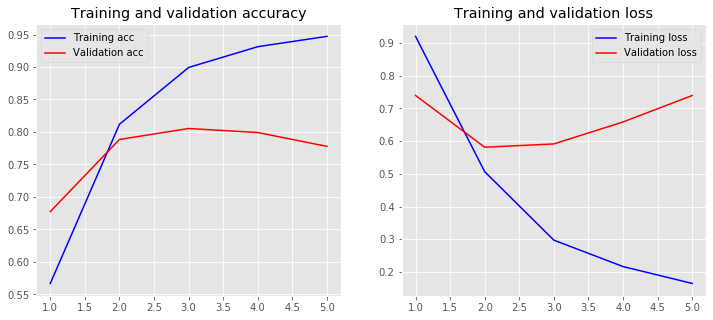

In [74]:
plot_history(history)

### d)- Checking results test set

In [75]:
y_test[:5]

171115    Benefit
271652    Neutral
225777      Risky
78578       Risky
9122      Benefit
Name: Sent_type, dtype: object

In [76]:
y_test_ohe[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [77]:
prediction=model.predict(X_test)
prediction[:5]

array([[5.9211308e-01, 2.4425059e-03, 4.0544447e-01],
       [7.2390134e-03, 9.8700273e-01, 5.7582562e-03],
       [2.7458286e-03, 1.9296386e-03, 9.9532449e-01],
       [9.7414193e-04, 2.9372901e-04, 9.9873215e-01],
       [9.8421186e-01, 7.3324400e-04, 1.5054807e-02]], dtype=float32)

In [80]:
df.head()

,TEXT,Sent_type,cleaned
443783,Unless you’re trying to buy me a Mercedes G-wa...,Neutral,unless youre trying buy mercedes gwagon dont t...
229375,Ford recently made news by suspending producti...,Risky,ford recently made news suspending production ...
20760,Just to get a closer look at the interior of o...,Neutral,get closer look interior 2009 bmw 3 series con...
337983,"In October 2014, General Motors got permission...",Risky,october 2014 general motors got permission fli...
247040,I took a spin in a self-driving car today. My ...,Benefit,took spin selfdriving car today safety driver ...


In [81]:
# checking with original text at index 225777. It is risky
df.TEXT.loc[225777]

'@eqtr8er My company is a big supplier to BMW. Trump will hurt all sub-suppliers w tariffs. We all supply German Companies'

In [82]:
df.loc[225777]

TEXT         @eqtr8er My company is a big supplier to BMW. ...
Sent_type                                                Risky
cleaned      eqtr8er company big supplier bmw trump hurt su...
Name: 225777, dtype: object

In [85]:
#[print(df['TEXT'][i], y_pred[i], y_test_ohe[i]) for i in range(0, 5)]



**Interpret**

- We have checked 1st five sentiment from 'text' feature. So, 1st column is text<br>
- 2nd column is predicted results. These are probability values of each sentiment. 0 ,1,2 as they were encoded. 'Risky':0, 'Beneficial':1, 'Neutral':2. So, 0 is risky, 1 is beneficial and 2 is neut. Probability of risky is 0.15, beneficial is 0.819 and neut is 0.119. Clearly, this text has tendency to be beneficial having highest probability<br>
- Third column shows real values of sentiment. Sequence is same as we encoded. And we can see that actual text was of beneficial sentiment. So, our prediction is correct in this case

In [86]:
ben_count, neu_count, risk_count = 0, 0, 0
real_ben, real_neu, real_risk = 0, 0, 0
for i, y_pred in enumerate(y_pred):
    if np.argmax(y_pred)==2:
        risk_count += 1
    elif np.argmax(y_pred)==1:
        neu_count += 1
    else:
        ben_count += 1
    
    if np.argmax(y_test_ohe[i])==2:
        real_risk += 1
    elif np.argmax(y_test_ohe[i])==1:    
        real_neu += 1
    else:
        real_ben +=1

print('Benefit predictions:', ben_count)
print('Neutral predictions:', neu_count)
print('Risk predictions:', risk_count)
print('Real Benefit values:', real_ben)
print('Real neutral values:', real_neu)
print('Real Risk values:', real_risk)

Benefit predictions: 1560
Neutral predictions: 1628
Risk predictions: 562
Real Benefit values: 1510
Real neutral values: 1607
Real Risk values: 633


test set has 1736.<br>
Real values are +ve as 444, neut 1077, neg 215<br>
We predicted +ve as 468, neut,1142, neg 126<br>

In [87]:
y_test.value_counts(ascending=True)

Risky       633
Benefit    1510
Neutral    1607
Name: Sent_type, dtype: int64